## Two Step Approach: Logistic Regression and DistilBert


### Import

In [85]:
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
import pandas as pd

import mlflow
import logging 
import config 


import numpy as np
import torch 
import os 
from mlflow.sklearn import save_model
from transformers import AutoModelForSequenceClassification, AutoConfig

# import mlflow.pytorch
os.environ["TOKENIZERS_PARALLELISM"] = "false"  # This tells Hugging Face: “Don’t use parallel tokenization — avoid possible deadlocks.”




In [77]:
from basic_functions import (
    get_lemmatized_data,
    get_metrics,
    get_encode_tokenize_data,
    createTrainer,
    get_eval_metrics
)

### Setup

In [ ]:
MODEL_NAME = "logreg_distilbert" 
TRACKING_URI = open("../.mlflow_uri").read().strip()
EXPERIMENT_NAME = config.EXPERIMENT_NAME

logging.basicConfig(format="%(asctime)s: %(message)s") # Configure logging format to show timestamp before every message

logger = logging.getLogger()
logger.setLevel(logging.INFO) # Only show logs that are INFO or more important (e.g., WARNING, ERROR) — but ignore DEBUG.

In [20]:
DATA_PATH = "../data/data_small.csv"

### Logistic Regression


#### Create Dataframe for Logistic Regression: Fallacy vs No Fallacy

In [30]:
df = pd.read_csv('../data/data.csv')
# Change text to lower cases
df['text'] = df['text'].apply(lambda x: x.lower())
df = df[df['logical_fallacies']!='slippery_slope']

In [32]:
def binary_classification(x):
    if x == 'none':
        return 'none'
    else:
        return 'fallacy'

In [33]:
df_logreg = df.copy()
df_logreg['two_class_target'] = df_logreg['logical_fallacies'].apply(binary_classification)

In [34]:
df_logreg.head()

,dataset,text,logical_fallacies,source,two_class_target
0,1,the world coal association disputed the conclu...,false_dilemma,https://www.nytimes.com/2018/10/07/climate/ipc...,fallacy
1,1,refusing to approve the document would place t...,appeal_to_emotion,https://www.nytimes.com/2018/10/07/climate/ipc...,fallacy
2,1,at 3 6 degrees of warming the report predicts ...,faulty_generalization,https://www.nytimes.com/2018/10/07/climate/ipc...,fallacy
3,1,scribbler and beckwith said the anomalies were...,faulty_generalization,https://www.independent.co.uk/news/science/cli...,fallacy
4,1,meanwhile mr beckwith confirmed the changes wo...,appeal_to_emotion,https://www.independent.co.uk/news/science/cli...,fallacy


#### Preprocess data: lemmatize, train-test-split, tokenizer

In [35]:
df_logreg = get_lemmatized_data(df_logreg)

In [36]:
df_logreg.two_class_target.value_counts()

two_class_target
fallacy    5695
none       5418
Name: count, dtype: int64

In [44]:
# stratified sample
df_logreg = df_logreg.groupby('two_class_target').apply(
    lambda x: x.sample(frac=0.45)
)

In [45]:
df_logreg.two_class_target.value_counts()

two_class_target
fallacy    2563
none       2438
Name: count, dtype: int64

<Axes: xlabel='two_class_target', ylabel='count'>

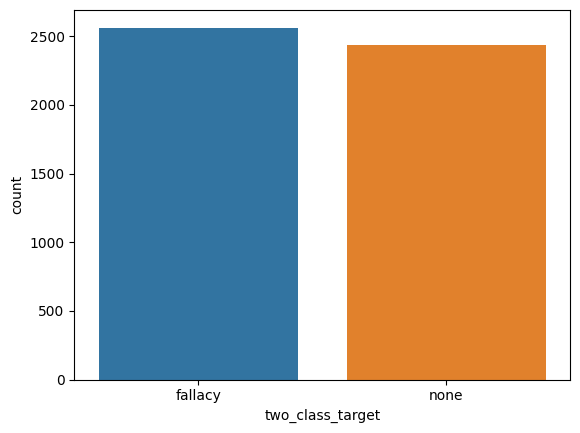

In [46]:
import seaborn as sns
sns.countplot(data=df_logreg, x='two_class_target')

In [47]:
y_logreg = df_logreg[["two_class_target", "logical_fallacies"]]
X_logreg = df_logreg["text"]

X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(
    X_logreg, y_logreg, test_size=0.30, random_state=42, stratify=y_logreg)

In [48]:
fa_train = y_train_lr["logical_fallacies"]
y_train_lr = y_train_lr["two_class_target"]
fa_test = y_test_lr["logical_fallacies"]
y_test_lr = y_test_lr["two_class_target"]

In [49]:
# Use TF-IDF Vecorizer to transform text into numerical data
tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),  # Bigrams (or even trigrams)
    max_features=5000,   # Limit feature space to the most important words
    min_df=5,            # Consider words that appear in at least 5 documents
    max_df=0.9           # Ignore words that appear in more than 90% of documents
)
X_vectorized_lr = tfidf_vectorizer.fit_transform(X_train_lr)
X_vectorized_test_lr = tfidf_vectorizer.transform(X_test_lr)

#### Initialize Binary classification model

In [50]:
logreg = LogisticRegression(
    penalty='l2',  # most of the solvers only work with l2
    random_state=42,
    class_weight='balanced', 
    verbose=0, 
    n_jobs=-1, 
    )

param_grid = {
'C': [ 10, 100, 150, 200],
'max_iter': [100, 500, 1000],
'solver': ['lbfgs', 'newton-cg', 'sag', 'saga', 'liblinear']
}

grid_search = GridSearchCV(logreg, param_grid, cv=5)
grid_search.fit(X_vectorized_lr, y_train_lr)

best_params = grid_search.best_params_
print(best_params)
logreg_model = grid_search.best_estimator_

/Users/katharinabaumgartner/Documents/NeueFische/scripts/34_capstone/Capstone_project/backend/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/katharinabaumgartner/Documents/NeueFische/scripts/34_capstone/Capstone_project/backend/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/katharinabaumgartner/Documents/NeueFische/scripts/34_capstone/Capstone_project/backend/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/katharinabaumgartner/Documents/NeueFische/scripts/34_capstone/Capstone_project/backend/.venv/lib/python3.11/site-pack

{'C': 10, 'max_iter': 100, 'solver': 'saga'}


/Users/katharinabaumgartner/Documents/NeueFische/scripts/34_capstone/Capstone_project/backend/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/katharinabaumgartner/Documents/NeueFische/scripts/34_capstone/Capstone_project/backend/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/katharinabaumgartner/Documents/NeueFische/scripts/34_capstone/Capstone_project/backend/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/katharinabaumgartner/Documents/NeueFische/scripts/34_capstone/Capstone_project/backend/.venv/lib/python3.11/site-pack

#### Evaluationg Logistic Regression

In [51]:
y_train_pred_lr = logreg_model.predict(X_vectorized_lr)
y_test_pred_lr = logreg_model.predict(X_vectorized_test_lr)

INFO:root:get train metrics for logistic regression
INFO:basic_functions:classification_report
INFO:basic_functions:confusion_matrix
INFO:basic_functions:heatmap


              precision    recall  f1-score   support

     fallacy       0.99      0.98      0.98      1794
        none       0.98      0.99      0.98      1706

    accuracy                           0.98      3500
   macro avg       0.98      0.98      0.98      3500
weighted avg       0.98      0.98      0.98      3500

[[1756   38]
 [  23 1683]]


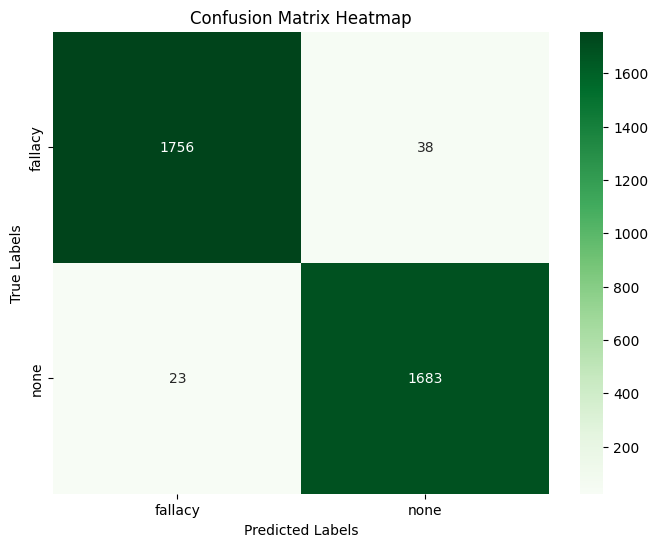

In [52]:
logger.info('get train metrics for logistic regression')
classification_report_one_train = get_metrics(y_train_lr, y_train_pred_lr)

INFO:root:get test metrics for logistic regression
INFO:basic_functions:classification_report
INFO:basic_functions:confusion_matrix
INFO:basic_functions:heatmap


              precision    recall  f1-score   support

     fallacy       0.77      0.73      0.75       769
        none       0.73      0.77      0.75       732

    accuracy                           0.75      1501
   macro avg       0.75      0.75      0.75      1501
weighted avg       0.75      0.75      0.75      1501

[[562 207]
 [166 566]]


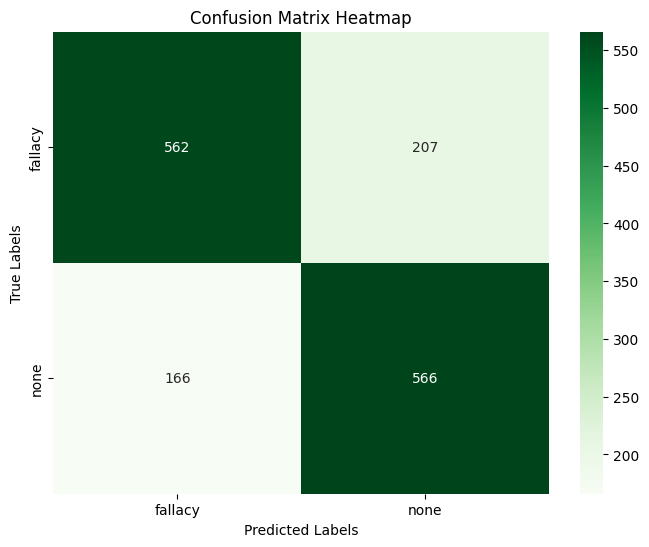

In [53]:
logger.info('get test metrics for logistic regression')
classification_report_one_test = get_metrics(y_test_lr, y_test_pred_lr)

### DistilBert

#### Get Data

In [79]:
MODEL_PATH = "distilbert-base-uncased"


In [66]:
df = pd.read_csv("../data/data.csv")
df_fallacies = df[df['logical_fallacies'] != 'none'] # remove 'none'
df_fallacies = df_fallacies[df_fallacies['logical_fallacies'] != 'slippery_slope'] # remove 'slippery slope'

In [67]:
df_fallacies.logical_fallacies.value_counts()

logical_fallacies
appeal_to_emotion        1619
faulty_generalization    1347
ad_hominem               1062
false_dilemma             941
appeal_to_authority       726
Name: count, dtype: int64

In [70]:

# Pick fallacies randomly, but as balanced as possible
# Configuration parameters
TARGET_SIZE = 4000
CLASSES = df_fallacies['logical_fallacies'].unique()

# Calculate target per class (integer division)
target_per_class = TARGET_SIZE // len(CLASSES)

# Stratified sampling with undersampling
sampled_dfs_fallacies = []
for class_name in CLASSES:
    class_dfss = df_fallacies[df_fallacies['logical_fallacies'] == class_name]
    sample_size = min(target_per_class, len(class_dfss))
    sampled_dfs_fallacies.append(class_dfss.sample(sample_size, random_state=42))

# Handle remaining samples
balanced_df_fallacies = pd.concat(sampled_dfs_fallacies)
remaining = TARGET_SIZE - len(balanced_df_fallacies)

if remaining > 0:
    extra_samples = df_fallacies[~df_fallacies.index.isin(balanced_df_fallacies.index)]
    balanced_df_fallacies = pd.concat([
        balanced_df_fallacies,
        extra_samples.sample(remaining, random_state=42)
    ])

# Final shuffle
balanced_df_fallacies = balanced_df_fallacies.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify distribution
print(balanced_df_fallacies['logical_fallacies'].value_counts())


logical_fallacies
appeal_to_emotion        832
faulty_generalization    821
ad_hominem               813
false_dilemma            808
appeal_to_authority      726
Name: count, dtype: int64


In [71]:
# stratified sample
df_fallacies_small = balanced_df_fallacies.groupby('logical_fallacies').apply(
    lambda x: x.sample(frac=0.5)
)

In [74]:
df_fallacies_small.to_csv("../data/data_fallacies_small.csv", index=False)

In [80]:
DATA_PATH = "../data/data_fallacies_small.csv"

In [81]:
train_dataset, test_dataset, encoded_train_dataset, encoded_test_dataset, le = get_encode_tokenize_data(DATA_PATH, MODEL_PATH)

INFO:basic_functions:Loading data...
INFO:basic_functions:Train test split, test-size 0.3
INFO:root:create encoded dataframes
INFO:root:encode the label column
INFO:root:tokenize
INFO:basic_functions:create tokenizer & load model
INFO:basic_functions:create tokenizer & load model
INFO:root:create TextDatasets (train & test)


In [82]:
y_train = encoded_train_dataset['logical_fallacies']

#### Model Initialization

In [83]:
learning_rate= 3e-5
weight_decay= 0.01
# num_train_epochs= 1
num_train_epochs= 4
evaluation_strategy= 'epoch'
class_weight=True
dropout= 0.3


params = {
      "learning_rate": learning_rate,
      "weight_decay": weight_decay,
      "num_train_epochs": num_train_epochs,
      "evaluation_strategy": evaluation_strategy,
      "class_weight":class_weight,
      "dropout": dropout,
      "dataset": DATA_PATH
  }


# setting the MLFlow connection and experiment
# mlflow.set_tracking_uri(TRACKING_URI)
# mlflow.set_experiment(EXPERIMENT_NAME)


# mlflow.start_run()
# run = mlflow.active_run()
# print("Active run_id: {}".format(run.info.run_id))

# mlflow.set_tag("model_name", MODEL_NAME)
# mlflow.set_tag("mlflow.runName", "distilbert finetuned")
# mlflow.log_params(params)

In [86]:
num_classes = len(np.unique(y_train))
num_classes

5

In [87]:
MODEL_TRAINING_PATH ="distilbert-base-uncased"


In [88]:
# Load config and set dropout
config = AutoConfig.from_pretrained(MODEL_TRAINING_PATH)
config.num_labels = num_classes # Set number of labels for classification
config.dropout = dropout # Set dropout, default is 0.1

# Load model with updated config
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_TRAINING_PATH,
    config=config  # Pass modified config
)

# model.gradient_checkpointing_enable() 

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [89]:
OUTPUT_DIR = "../models/logreg_distilbert/trainer_output"
SAVE_PATH = "../models/logreg_distilbert/pytorch_model"

In [90]:
trainer = createTrainer(
    model= model, 
    train_dataset = train_dataset,
    test_dataset = test_dataset,
    output_dir= OUTPUT_DIR, 
    y_train=y_train, 
    class_weight=class_weight, 
    epochs=num_train_epochs, 
    learning_rate=learning_rate, 
    weight_decay = weight_decay, 
    train_batch_size=4, 
    eval_batch_size=8 )

INFO:root:defining training arguments
INFO:root:get weighted loss trainer


#### Execute Training


In [92]:
torch.mps.empty_cache()  # Clears unused GPU memory

# disable upper limit for memory
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"

# Allows up to 100% of available memory
torch.mps.set_per_process_memory_fraction(1.0)  

In [93]:
logger.info('training is running')
trainer.train()

INFO:root:training is running


Epoch,Training Loss,Validation Loss,Accuracy
1,0.985000,0.990363,0.625000
2,0.672400,0.940412,0.653333
3,0.420300,1.052621,0.700000
4,0.370100,1.166955,0.693333


TrainOutput(global_step=1400, training_loss=0.6782433019365584, metrics={'train_runtime': 1358.7088, 'train_samples_per_second': 4.119, 'train_steps_per_second': 1.03, 'total_flos': 741327222312960.0, 'train_loss': 0.6782433019365584, 'epoch': 4.0})

#### DistilBert Evaluation

In [94]:
def log_metrics(cr, brier, split):
    mlflow.log_metric(f"{split}_brier", brier)

    for key, value in cr.items():
        if (key == "accuracy"):
                # print(f"{split}_{key}", round(value,2))
                mlflow.log_metric(f"{split}_{key}", value)
        else:
            for metric in value:
                mlflow.log_metric(f"{split}_{key}_{metric}", value.get(metric))
                # print(f"{split}_{key}_{metric}", round(value.get(metric),2))

    

INFO:root:predict on test_dataset


INFO:basic_functions:get evaluation metrics
INFO:basic_functions:classification_report
INFO:basic_functions:confusion_matrix
INFO:basic_functions:heatmap


                       precision    recall  f1-score   support

           ad_hominem       0.64      0.74      0.69       122
  appeal_to_authority       0.60      0.77      0.68       109
    appeal_to_emotion       0.64      0.58      0.61       125
        false_dilemma       0.71      0.79      0.75       121
faulty_generalization       0.69      0.41      0.52       123

             accuracy                           0.65       600
            macro avg       0.66      0.66      0.65       600
         weighted avg       0.66      0.65      0.65       600



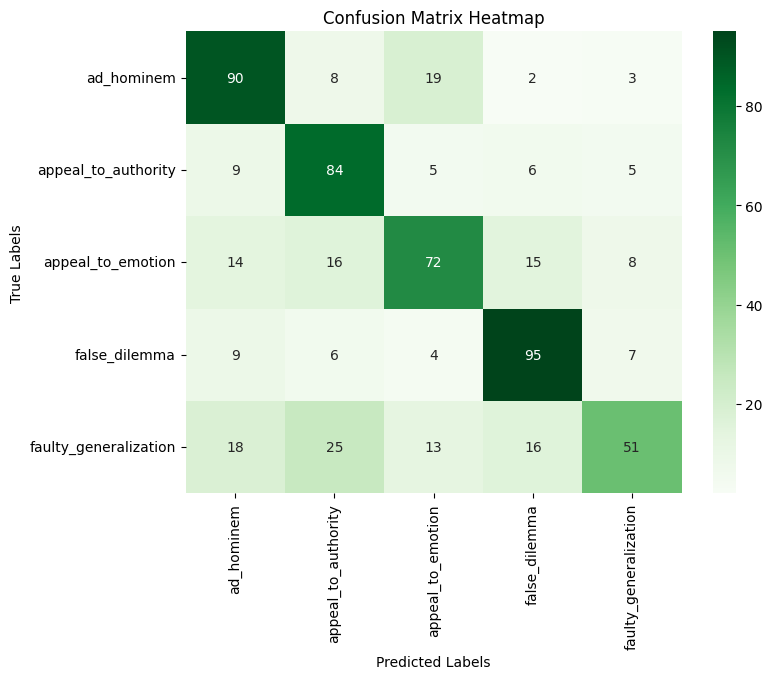

INFO:basic_functions:brier score


Multiclass Brier score: 0.48413037123214925


In [95]:
logger.info('predict on test_dataset')
test_output = trainer.predict(test_dataset)

classification_report, brier = get_eval_metrics(test_output, le)
log_metrics(classification_report, brier, "test")


INFO:root:predict on train_dataset


INFO:basic_functions:get evaluation metrics
INFO:basic_functions:classification_report
INFO:basic_functions:confusion_matrix
INFO:basic_functions:heatmap


                       precision    recall  f1-score   support

           ad_hominem       0.83      0.93      0.88       284
  appeal_to_authority       0.81      0.96      0.88       254
    appeal_to_emotion       0.91      0.82      0.86       291
        false_dilemma       0.92      0.92      0.92       283
faulty_generalization       0.91      0.75      0.82       287

             accuracy                           0.87      1399
            macro avg       0.88      0.87      0.87      1399
         weighted avg       0.88      0.87      0.87      1399



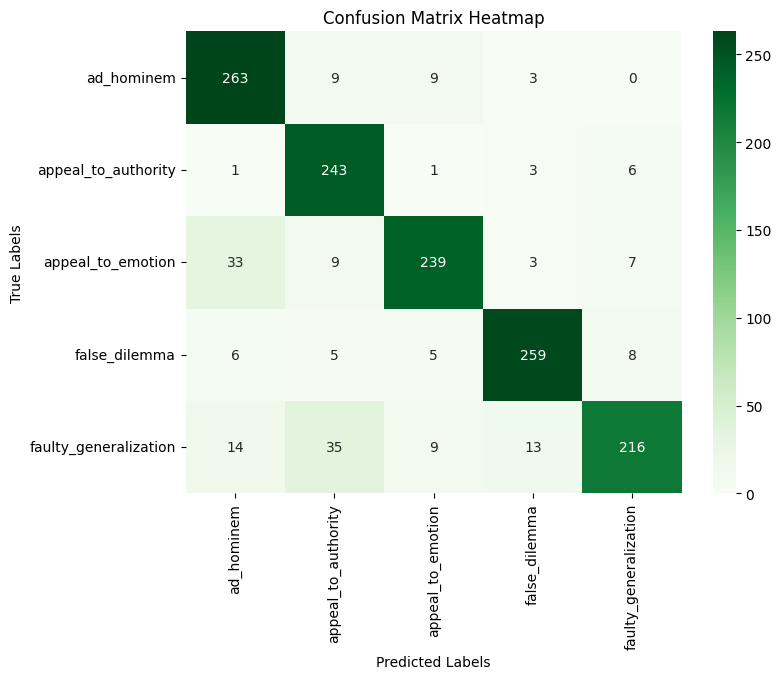

INFO:basic_functions:brier score


Multiclass Brier score: 0.1929946276087391


In [96]:
logger.info('predict on train_dataset')
train_output = trainer.predict(train_dataset)

classification_report, brier= get_eval_metrics(train_output, le)
log_metrics(classification_report, brier, "train")


### Two Step Prediction

In [ ]:
# get validation data! which is not seen for both!

In [ ]:
X_val = df_val['text']
X_vectorized_val = tfidf_vectorizer.transform(X_val)
y_val = logreg_model.predict()

In [ ]:
df_pred =  df_val.copy()
df_pred['pred'] = y_val
df_pred = df_pred[df_pred["binary_prediction"] != "none"]

In [ ]:
# encode and tokenize
# predict with distilbert